<a href="https://colab.research.google.com/github/LUUTHIENXUAN/ConvMixer/blob/main/ConvMixer_public_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with the latest Conv-Mixer models

**Author:** [LUU THIEN XUAN](https://www.linkedin.com/in/thienxuanluu/)<br>
**Date created:** 2021/10/13<br>
**Last modified:** 2021/10/13<br>
**Description:** Implementing the Conv-Mixer models for CIFAR-100 image classification.

https://openreview.net/forum?id=TVHS5Y4dNvM


# Introduction

This example implements the recent paper **Patches Are All You Need**, demonstrated on the CIFAR-100 dataset:

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```shell
pip install -U tensorflow-addons
```

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
print('tf:',tf.__version__)

     |████████████████████████████████| 1.1 MB 8.2 MB/s 
tf: 2.6.0


## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
weight_decay = 0.0001
batch_size = 64
num_epochs = 150
dropout_rate = 0.2

image_size = 64  # We'll resize input images to this size.

## Build a classification model

We implement a method that builds a classifier given the processing blocks.

In [ ]:
def build_classifier(blocks):
  
  inputs = layers.Input(shape=input_shape)
  # Augment data.
  augmented = data_augmentation(inputs)
  
  # Process x using the module blocks.
  x = blocks(augmented)
  
  # Apply global average pooling
  representation = layers.GlobalAveragePooling2D()(x)
  # Apply dropout.
  representation = layers.Dropout(rate=dropout_rate)(representation)
  # Compute logits outputs.
  logits = layers.Dense(num_classes)(representation)
  # Create the Keras model.
  return keras.Model(inputs=inputs, outputs=logits)

## Define an experiment

We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
  
  # Create Adam optimizer with weight decay.
  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay,)
  
  # Compile the model.
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],)
  
  # Create a learning rate scheduler callback.
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5)
  
  # Create an early stopping callback.
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
  
  # Fit the model.
  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[early_stopping, reduce_lr],
    )

  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  # Return history to plot learning curves.
  return history

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


# ConvMixer model


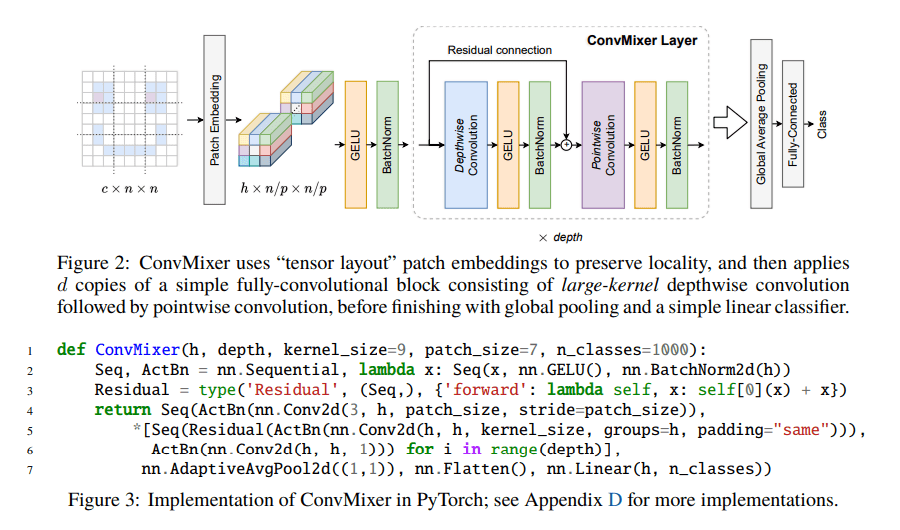

### Implement the ConvMixer module

In [ ]:
class Residual(layers.Layer):
  def __init__(self, fn, *args, **kwargs):
    super(Residual, self).__init__(*args, **kwargs)
    self.fn = fn
  
  @tf.function(jit_compile=True)
  def call(self, x):
    return self.fn(x) + x

class ConvMixer(layers.Layer):
  def __init__(self, dim=None, kernel_size=9, *args, **kwargs):
    super(ConvMixer, self).__init__(*args, **kwargs)
    self.dim = dim
    self.kernel_size = kernel_size
    # Depthwise convolution.
    self.cmixer = keras.Sequential([
                    layers.DepthwiseConv2D(kernel_size=self.kernel_size, padding="same"),                
                    #layers.Conv2D(self.dim, self.kernel_size, groups=self.dim, padding="same"),
                    tfa.layers.GELU(),
                    layers.BatchNormalization()])
    self.Conv2d = layers.Conv2D(dim, kernel_size=1)
    self.GELU = tfa.layers.GELU()
    self.BatchNorm2d = layers.BatchNormalization()
    
  @tf.function(jit_compile=True)
  def call(self, inputs):
    # Depthwise convolution.
    x = Residual(self.cmixer)(inputs)
    # Pointwise convolution.
    x = self.Conv2d(x)
    x = self.GELU(x)
    x = self.BatchNorm2d(x)
    return x

### Build, train, and evaluate the ConvMixer model


####conv_mixer_256_8

In [ ]:
cmlp_dim    = 256
cmlp_depth  = 8
cmlp_kernel = 5
cmlp_patch  = 2

cmlp_blocks = keras.Sequential(
    [ # Extract patch embeddings.
      layers.Conv2D(cmlp_dim, kernel_size=cmlp_patch, strides=cmlp_patch),
      tfa.layers.GELU(),
      layers.BatchNormalization(),
      # ConvMixer blocks.
      keras.Sequential(
          [
           ConvMixer(dim=cmlp_dim, kernel_size=cmlp_kernel) for _ in range(cmlp_depth)
          ])
    ])

learning_rate = 0.003
cmlp_classifier = build_classifier(cmlp_blocks)
history = run_experiment(cmlp_classifier)

Epoch 1/150
704/704 [==============================] - 180s 222ms/step - loss: 4.0770 - acc: 0.0680 - top5-acc: 0.2393 - val_loss: 3.8103 - val_acc: 0.1158 - val_top5-acc: 0.3266
Epoch 2/150
704/704 [==============================] - 150s 213ms/step - loss: 3.6620 - acc: 0.1237 - top5-acc: 0.3690 - val_loss: 3.5683 - val_acc: 0.1376 - val_top5-acc: 0.4034
Epoch 3/150
704/704 [==============================] - 150s 213ms/step - loss: 3.3091 - acc: 0.1893 - top5-acc: 0.4736 - val_loss: 3.1943 - val_acc: 0.2184 - val_top5-acc: 0.5032
Epoch 4/150
704/704 [==============================] - 150s 213ms/step - loss: 2.9757 - acc: 0.2561 - top5-acc: 0.5616 - val_loss: 2.7921 - val_acc: 0.2964 - val_top5-acc: 0.6092
Epoch 5/150
704/704 [==============================] - 150s 213ms/step - loss: 2.7449 - acc: 0.2996 - top5-acc: 0.6144 - val_loss: 2.7358 - val_acc: 0.3074 - val_top5-acc: 0.6212
Epoch 6/150
704/704 [==============================] - 150s 213ms/step - loss: 2.5402 - acc: 0.3438 - top

###Visualizing the internals of ConvMixer

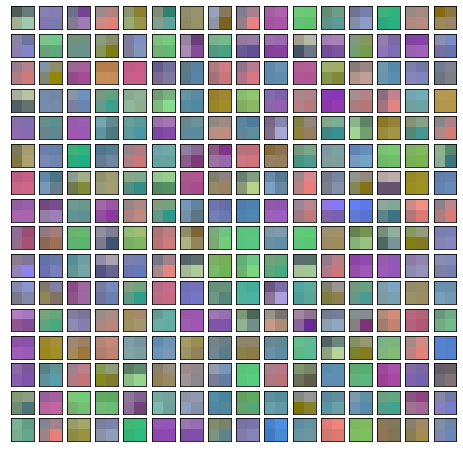

In [ ]:
import matplotlib.pyplot as plt
# Code reference: https://bit.ly/3awIRbP.

def visualization_plot(weights, idx=1):
  # First, apply min-max normalization to the
  # given weights to avoid isotrophic scaling.
  p_min, p_max = weights.min(), weights.max()
  weights = (weights - p_min) / (p_max - p_min)

  # Visualize all the filters.
  num_filters = 256
  plt.figure(figsize=(8, 8))

  for i in range(num_filters):
    current_weight = weights[:, :, :, i]
    if current_weight.shape[-1] == 1:
      current_weight = current_weight.squeeze()
    ax = plt.subplot(16, 16, idx)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(current_weight)
    idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = cmlp_classifier.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)